In [1]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Summary of changes after meeting on 11/1
1. Used inverse of lift to MDS (align with the slides)
2. Fixed random_state in MDS (you can change it and see which works the best for you)
3. Completed task C
4. Completed task E, you can change the words in the list and see what happens

## Scraper
First of all, don't run it!, it took me hours to scrape all the data (It should not have taken so long but I don't know why).

Secondly, I scraped around 7500 most recent pieces of comment instead of 5000 because the most recent 5000 comments are contributed by 68 users. With 7500 comments, we can get opioins from 130 users, which diversifys our data.

In [80]:
# %%time

# #change directory where you put your chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# driver = webdriver.Chrome("chromedriver", options=options)

# all_comments = pd.DataFrame(columns = ['Date','user_id', 'comments']) 

# x = 284
# pages_scraped = 434
# driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(x))

# while x <= pages_scraped:
#     print("page",x)
    
#     if x > 1:
#         driver.find_element_by_link_text("{}".format(x)).click()
#         driver.implicitly_wait(3)
    
#     ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
#     comment_ids = []
#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     for d in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         if driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]')[0]
#             comment = user_message.text
#         else: 
#             comment = None
        
#         #Adding date, userid and comment for each user in a dataframe    
#         all_comments.loc[len(all_comments)] = [date,userid,comment]
        
#     x += 1

In [81]:
# all_comments.to_csv("7500_comments_edmunds.csv", sep="\t")

## Check the data
We have 7506 rows of comments from 2012-8-10 to 2019-8-21, comtibuted by 130 users.

In [2]:
df = pd.read_csv("7500_comments_edmunds.csv", sep="\t", parse_dates=['Date'])
df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

In [83]:
df.shape

(7506, 3)

In [84]:
df['Date'].max()

Timestamp('2019-08-21 02:25:00')

In [85]:
df['Date'].min()

Timestamp('2012-08-10 01:45:00')

In [86]:
len(df['user_id'].value_counts())

130

### Preprocess comments

In [3]:
%%time
# tokenization
df['tokens'] = df['comments'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 21.8 s


## Replace model to brand

In [6]:
%%time
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'mercedes benz'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'
models.loc[(models['brand'] == 'kia,'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyndai kia'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyundai,'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'hyundai.'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'nissan.'),'brand'] = 'nissan'
models.loc[(models['brand'] == 'toyata'),'brand'] = 'toyota'
models.loc[(models['brand'] == 'volkwagen'),'brand'] = 'volkswagen'



def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[-1,0]
#         print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

Wall time: 15.1 s


## Check frequency

In [8]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()
# word_frequency

## Task A: get top 10 list
Filter brands from word_frequency

In [10]:
brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw              2551
audi             1911
acura            1134
honda            1000
infiniti          662
volkswagen        539
toyota            488
mercedes-benz     411
hyundai           396
ford              376
dtype: int64

## Task A: calculate lift ratios for associations between the brands

#### Test case

In [11]:
# lift(bmw, audi)
a = 'bmw'
b = 'audi'
N = df['processed'].shape[0]
N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
N_a = sum(df['processed'].map(lambda x: a in x))
N_b = sum(df['processed'].map(lambda x: b in x))
print(N, N_ab, N_a, N_b, N*N_ab/(N_a*N_b))

def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

7506 567 1930 1234 1.7869777714328903


In [12]:
lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand'])
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make))
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.179733,1.380993,2.622126,1.247200,1.406985
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.580048,1.508753,3.480728,1.803823,1.224836
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.392939,1.553917,2.617041,1.531524,1.121724
honda,1.098865,1.583850,3.260322,10.396122,1.409297,2.138020,3.202983,1.737595,1.828284,2.022454
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.250994,1.617116,3.467322,2.034009,1.258239
volkswagen,1.179733,2.580048,1.392939,2.138020,1.250994,19.295630,2.367871,1.639855,2.195710,2.831782
toyota,1.380993,1.508753,1.553917,3.202983,1.617116,2.367871,19.597911,1.998654,3.041055,2.742370
mercedes-benz,2.622126,3.480728,2.617041,1.737595,3.467322,1.639855,1.998654,21.263456,2.126346,2.177146
hyundai,1.247200,1.803823,1.531524,1.828284,2.034009,2.195710,3.041055,2.126346,25.882759,2.031752


In [13]:
inverse_lift_brands = lift_brands.apply(lambda x: 1/x)
inverse_lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,0.257128,0.559604,0.754420,0.910030,0.527734,0.847650,0.724117,0.381370,0.801796,0.710740
audi,0.559604,0.164402,0.459998,0.631373,0.385625,0.387590,0.662799,0.287296,0.554378,0.816436
acura,0.754420,0.459998,0.112577,0.306718,0.303182,0.717907,0.643535,0.382111,0.652944,0.891485
honda,0.910030,0.631373,0.306718,0.096190,0.709573,0.467722,0.312209,0.575508,0.546961,0.494449
infiniti,0.527734,0.385625,0.303182,0.709573,0.067812,0.799365,0.618385,0.288407,0.491640,0.794762
volkswagen,0.847650,0.387590,0.717907,0.467722,0.799365,0.051825,0.422320,0.609810,0.455434,0.353135
toyota,0.724117,0.662799,0.643535,0.312209,0.618385,0.422320,0.051026,0.500337,0.328833,0.364648
mercedes-benz,0.381370,0.287296,0.382111,0.575508,0.288407,0.609810,0.500337,0.047029,0.470290,0.459317
hyundai,0.801796,0.554378,0.652944,0.546961,0.491640,0.455434,0.328833,0.470290,0.038636,0.492186


## MDS plot

In [14]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, random_state=4)
mds = embedding.fit_transform(inverse_lift_brands)
mds_output = pd.DataFrame(mds, index=inverse_lift_brands.index.values, columns=['x', 'y'])
mds_output

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


,x,y
bmw,-0.367376,0.782580
audi,-0.409547,-0.107489
acura,-0.562045,-0.491723
honda,0.252681,-0.625381
infiniti,-0.736055,0.087601
volkswagen,0.726127,-0.098010
toyota,0.463266,-0.267686
mercedes-benz,-0.383009,0.242688
hyundai,0.284235,0.103132
ford,0.731723,0.374289


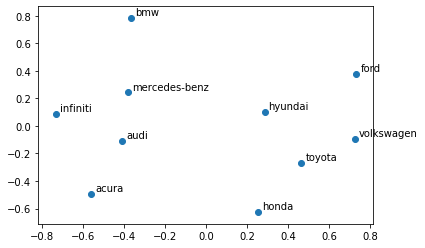

In [15]:
fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for brand in inverse_lift_brands.index.values:
    ax.text(mds_output.loc[brand, 'x']+0.02, mds_output.loc[brand, 'y']+0.02, brand)

##  <font color='red'>Task B: Insights</fonr>
TBD

## Task C
I went over 1500 words, picked and grouped words with intuition. 

Since professor said we don't have to do a sentiment analysis, I group positive and negative words together. For example, I grouped 'small' and 'large' into size attributes. 

Find 5 most frequently mentioned attributes.

In [16]:
# word_frequency[:500]

In [17]:
# attribute_dict = { 
#     'performance': ['drive', 'engine', 'sport', 'driving', 'performance', 'power', 'spped', 
#                     'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
#     'fuel_efficiency': ['mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel'],
    
#     'look': ['look', 'nice', 'looking', 'design', 'nicer', 'style', 'attractive', 'designed', 'looked'],
    
#     'luxury': ['great', 'brand', 'luxury', 'best', 'premium'],
    
#     'reliability': ['issue', 'problem', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
#                    'service', 'warranty', 'durability', 'quality'],
    
#     'price': ['money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
#              'cheap', 'cheaper', 'incentive', 'worth'],
    
#     'size': ['big', 'huge', 'large', 'size', 'weight', 'bigger', 'sticker', 'roof',
#             'little', 'small', 'light', 'smaller', 'biggest'],

#     'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet'],

#     'experience': ['experience', 'speciall', 'interesting', 'impressive', 'surprised', 'amazing', 
#                    'fun', 'happy', 'enthusiast'],
    
#     'safety': ['safety', 'life', 'safe']}

In [22]:
attribute_dict = { 
    'performance': ['drive', 'engine', 'sport', 'driving', 'performance', 'power', 'speed', 
                    'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'fuel_efficiency': ['mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel'],
    
    'look': ['look', 'nice', 'looking', 'design', 'nicer', 'style', 'attractive', 'designed', 'looked'],
    
    'luxury': ['great', 'brand', 'luxury', 'best', 'premium'],
    
    'reliability': ['suspension', 'reliable',
                   'service', 'warranty', 'durability', 'quality'],
    
    'low_price': ['money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand',
             'cheap', 'cheaper', 'incentive', 'worth'],
    
    'high_price': ['money', 'msrp', 'price', 'offer', 'grand', 'expensive','incentive', 'worth'],

    'small_size': ['size', 'weight', 'bigger', 'roof', 'little', 'small', 'light', 'smaller'],

    'large_size': ['big', 'huge', 'large', 'size', 'weight', 'bigger', 'sticker', 'roof', 'biggest'],

    'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio',  'quiet'],

    'experience': ['experience', 'speciall', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'enthusiast'],
    
    'safety': ['safety', 'life', 'safe']}

## Task C: Find top 5 attributes

In [28]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attributes = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attributes = top_attributes.sort_values(by=['count'], ascending=False)
top_attributes

,attribute_terms,count
performance,"[drive, engine, sport, driving, performance, p...",2736
low_price,"[money, msrp, price, sale, offer, discount, ba...",2153
high_price,"[money, msrp, price, offer, grand, expensive, ...",1878
look,"[look, nice, looking, design, nicer, style, at...",1863
luxury,"[great, brand, luxury, best, premium]",1654
fuel_efficiency,"[mile, mileage, oil, diesel, mpg, gas, fuel]",1362
experience,"[experience, speciall, interesting, impressive...",1262
small_size,"[size, weight, bigger, roof, little, small, li...",1206
large_size,"[big, huge, large, size, weight, bigger, stick...",1145
interior,"[seat, interior, leather, steering, inside, ra...",1077


## Task C: Which attributes are most strongly associated with which of the top 5 brands?

In [25]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [29]:
brand_list = top10_brands[:5]

for attribute in top_attributes.index.values[:5]:
    print(attribute)
    output = lift_attribute_to_brands(attribute, attribute_dict, brand_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(output)
    print('')

performance
audi        1.518441
bmw         1.469791
infiniti    1.439083
honda       1.394509
acura       1.357101
dtype: float64

low_price
infiniti    1.856163
audi        1.709247
acura       1.596683
bmw         1.540835
honda       1.521030
dtype: float64

high_price
infiniti    1.790317
audi        1.752246
bmw         1.580084
honda       1.561079
acura       1.546693
dtype: float64

look
audi        1.629225
acura       1.597290
infiniti    1.591014
honda       1.579228
bmw         1.317249
dtype: float64

luxury
infiniti    2.130851
audi        1.908645
acura       1.858200
honda       1.835349
bmw         1.497805
dtype: float64



## <font color='red'>Task D</font>
 TBD 

## Task E: The most aspirational brand 
### You can play around with different words by changing the words in the list below.

We can also try bigram, trigram if possible.

In [101]:
aspiration_dict = { 'aspiration': ['want', 'like', 'best', 'love', 'wanted', 'dream'] }

In [102]:
brand_list = top10_brands

output = lift_attribute_to_brands('aspiration', aspiration_dict, brand_list, df)
output = pd.Series(output).sort_values(ascending=False)
print(output)
print('')

mercedes-benz    1.641880
infiniti         1.542057
audi             1.514346
toyota           1.492916
honda            1.468704
ford             1.445877
acura            1.411781
volkswagen       1.384729
bmw              1.372234
hyundai          1.353288
dtype: float64

